In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

c:\Users\santu\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Baseline Modeling
##### Random Recommendation

In [2]:
df = pd.read_csv("../data/raw/ratings.csv")
# df = df.sample(n=500_000, random_state=42).reset_index(drop=True)

# user_counts = df['userId'].value_counts()
# # active_users = user_counts[user_counts >= 30].index

# movie_counts = df['movieId'].value_counts()
# popular_movies = movie_counts[movie_counts >= 30].index

# df = df[df['userId'].isin(active_users) & df['movieId'].isin(popular_movies)]

# df = df.reset_index(drop=True)
print(f"Jumlah user unik: {df['userId'].nunique()}")
print(f"Jumlah movie unik: {df['movieId'].nunique()}")
print(f"Jumlah rating: {df.shape[0]}")
print(df.head())

Jumlah user unik: 610
Jumlah movie unik: 9724
Jumlah rating: 100836
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [3]:
# # 1. Load rating data
# df = pd.read_csv("../data/raw/ratings.csv")

# N_USER = 3000
# N_MOVIE = 3000

# # 1. Top N user & movie (paling aktif/populer)
# top_users = df['userId'].value_counts().head(N_USER).index
# top_movies = df['movieId'].value_counts().head(N_MOVIE).index

# # 2. Subset df sesuai top user & movie
# df = df[df['userId'].isin(top_users) & df['movieId'].isin(top_movies)].copy()
# df = df.reset_index(drop=True)

# # 3. Print info hasil subset
# print(f"Jumlah user unik: {df['userId'].nunique()}")
# print(f"Jumlah movie unik: {df['movieId'].nunique()}")
# print(f"Jumlah rating: {df.shape[0]}")
# print(df.head())

In [4]:
def split_per_user(df, user_col='userId', frac_test=0.2, seed=42):
    df = df.copy()
    rng = np.random.default_rng(seed)
    df['_rand'] = rng.random(df.shape[0])
    df = df.sort_values([user_col, '_rand'])
    df['_row'] = df.groupby(user_col).cumcount()
    n_test_per_user = df.groupby(user_col).size().apply(lambda x: max(1, int(x*frac_test)))
    df['_n_test'] = df[user_col].map(n_test_per_user)
    df['_is_test'] = df['_row'] < df['_n_test']
    test_df = df[df['_is_test']].drop(columns=['_rand','_row','_n_test','_is_test'])
    train_df = df[~df['_is_test']].drop(columns=['_rand','_row','_n_test','_is_test'])
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

train_df, test_df = split_per_user(df, user_col='userId', frac_test=0.2, seed=42)
print(train_df.shape, test_df.shape)

(80896, 4) (19940, 4)


In [114]:
trainset = train_df.groupby('userId')['movieId'].apply(set).to_dict()
testset = test_df.groupby('userId')['movieId'].apply(set).to_dict()

In [118]:
def evaluation(K,recommendation,test_data):
    precision_list, recall_list, hit_list = [], [], []
    count = 0
    for user,rec_items in recommendation.items():
        true_items = test_data[user]
        hits = set(true_items) & set(rec_items)
        precision = len(hits) / max(1, len(rec_items))
        recall = len(hits)/len(true_items)
        hit = 1 if len(hits) > 0 else 0
        precision_list.append(precision)
        recall_list.append(recall)
        hit_list.append(hit)
    
    return {
        'precision@K_mean': np.mean(precision_list),
        'recall@K_mean': np.mean(recall_list),
        'hit@K_mean': np.mean(hit_list),
    }

In [122]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from scipy.sparse import coo_matrix

user_mapping = {uid: idx for idx, uid in enumerate(train_df['userId'].unique())}
item_mapping = {mid: idx for idx, mid in enumerate(train_df['movieId'].unique())}

def encode(df):
    return df['userId'].map(user_mapping), df['movieId'].map(item_mapping)

# 2. Interaction matrices
row, col = encode(train_df)
train_mat = coo_matrix((np.ones_like(row), (row, col)), 
                       shape=(len(user_mapping), len(item_mapping)))
row_t, col_t = encode(test_df)
test_mat = coo_matrix((np.ones_like(row_t), (row_t, col_t)),
                      shape=(len(user_mapping), len(item_mapping)))

def get_metrics(model, train_mat, test_mat, k=10):
    prec_arr = precision_at_k(model, test_mat, train_interactions=train_mat, k=k)
    recall_arr = recall_at_k(model, test_mat, train_interactions=train_mat, k=k)
    hit_rate = np.mean(prec_arr > 0)
    metrics = {
        'precision@{}'.format(k): np.mean(prec_arr),
        'recall@{}'.format(k): np.mean(recall_arr),
        'hit_rate@{}'.format(k): hit_rate
    }
    return metrics

# 3. Random baseline
random_model = LightFM(no_components=1, loss='warp')
random_model.fit(train_mat, epochs=0)
metrics_random = get_metrics(random_model, train_mat, test_mat, k=10)
print("Random (LightFM) baseline:", metrics_random)

# 4. Popularity baseline
popularity_model = LightFM(no_components=1, loss='logistic')
popularity_model.fit(train_mat, epochs=1)
metrics_pop = get_metrics(popularity_model, train_mat, test_mat, k=10)
print("Popularity (LightFM) baseline:", metrics_pop)

Random (LightFM) baseline: {'precision@10': 0.005081967, 'recall@10': 0.0016802579229261176, 'hit_rate@10': 0.05081967213114754}
Popularity (LightFM) baseline: {'precision@10': 0.14491802, 'recall@10': 0.06596732211288017, 'hit_rate@10': 0.6}


## 📊 **Evaluasi dan Insight Model Rekomendasi**

---

### 🎲 **1. Random Recommender**

**Hasil:**

* Precision\@10: **0.005**
* Recall\@10: **0.0016**
* Hit Rate\@10: **0.051**

**Insight:**

> Model random benar-benar hanya memberi rekomendasi secara acak, tanpa memperhatikan data atau pola apa pun. Hasil evaluasi yang sangat rendah ini memang sudah sesuai ekspektasi dan menjadi acuan paling bawah (baseline minimal) yang wajib dikalahkan model lain.

---

### 🌟 **2. Popularity Recommender**

**Hasil:**

* Precision\@10: **0.145**
* Recall\@10: **0.067**
* Hit Rate\@10: **0.60**

**Insight:**

> Model popularitas memberikan peningkatan yang signifikan dibanding random. Ini membuktikan kalau film yang populer memang cenderung juga disukai oleh banyak user. Namun, kelemahannya adalah rekomendasi jadi sangat tidak personal (semua user dapat rekomendasi yang sama) dan sulit merekomendasikan film baru atau niche.

---

### Collaborative Filtering

In [96]:
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
user_ids = train_df['userId'].astype('category').cat.codes
movie_ids = train_df['movieId'].astype('category').cat.codes
user_ids.shape, movie_ids.shape

# user_item = coo_matrix((train_df['rating'], (user_ids, movie_ids)))
# user_item_df = pd.DataFrame(user_item.toarray(), 
#                             index=train_df['userId'].astype('category').cat.categories, 
#                             columns=train_df['movieId'].astype('category').cat.categories)
# user_item_df.shape

((80896,), (80896,))

In [97]:
# def collaborative_filtering_fast(user_item_df, trainset, K):
#     similarity = cosine_similarity(user_item_df)
#     unique_user_ids = user_item_df.index
#     sim_df = pd.DataFrame(similarity, index=unique_user_ids, columns=unique_user_ids)

#     mean_rating_user = user_item_df.replace(0, np.nan).mean(axis=1).fillna(0)

#     recommendation = dict()
#     all_movie_ids = set(user_item_df.columns)

#     for user in trainset:
#         rated_items = trainset[user]
#         candidate_items = list(all_movie_ids - rated_items)
#         neighbors = sim_df.loc[user].drop(user).sort_values(ascending=False).head(K).index
#         sim_scores = sim_df.loc[user, neighbors]
#         pred_score = dict()

#         for idx in candidate_items:
#             neighbor_ratings = user_item_df.loc[neighbors, idx]
#             mean_neighbors = mean_rating_user.loc[neighbors]

#             mask = neighbor_ratings != 0
#             if not mask.any():
#                 pred = mean_rating_user.loc[user]
#             else:
#                 sim_valid = sim_scores[mask]
#                 rating_valid = neighbor_ratings[mask]
#                 mean_valid = mean_neighbors[mask]
#                 numerator = (sim_valid * (rating_valid - mean_valid)).sum()
#                 denominator = np.abs(sim_valid).sum()
#                 if denominator == 0:
#                     pred = mean_rating_user.loc[user]
#                 else:
#                     pred = mean_rating_user.loc[user] + numerator / denominator
#             pred_score[idx] = pred

#         top_20 = sorted(pred_score.items(), key=lambda x: x[1], reverse=True)[:20]
#         rec = [movie_id for movie_id, pred in top_20]
#         recommendation[user] = rec
#     return recommendation

In [98]:
from surprise import Reader,Dataset,KNNBasic,accuracy,SVD
from surprise.model_selection import train_test_split
reader = Reader(rating_scale=(0.5,5))
data = Dataset.load_from_df(train_df[['userId','movieId','rating']], reader)

train_items = set(train_df['movieId'].unique())
test_items = set(test_df['movieId'].unique())
trainset = data.build_full_trainset()
test_df = test_df[test_df['movieId'].isin(train_items)].reset_index(drop=True)
testset = list(test_df[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))

algo_user = KNNBasic(sim_options={'name':'pearson_baseline','user_based':True},k=100,min_k=5)
algo_user.fit(trainset)
# algo_item = KNNBasic(sim_options={'name':'cosine','user_based':False},k=K)
# algo_item.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [99]:
from collections import defaultdict
import heapq

all_items = set(train_df['movieId'].unique())

user_rated = train_df.groupby('userId')['movieId'].apply(set).to_dict()
test_rated = test_df.groupby('userId')['movieId'].apply(set).to_dict()

def model_recommend(algo, user_rated, all_items, topk=10):
    recommendation = dict()
    for user in user_rated:
        candidate_items = list(all_items - user_rated[user])
        preds = [(iid, algo.predict(user, iid).est) for iid in candidate_items]
        top_items = sorted(preds, key=lambda x: x[1], reverse=True)[:topk]
        recommendation[user] = [iid for iid, _ in top_items]
    return recommendation

In [100]:
recommendation_user = model_recommend(algo_user,user_rated,all_items,K)
testset_dict = test_df.groupby('userId')['movieId'].apply(set).to_dict()
print(f"Skor user-user recommender: {evaluation(K,recommendation_user,testset_dict)}")

Skor user-user recommender: {'precision@K_mean': 0.009016393442622951, 'recall@K_mean': 0.0036820943691410345, 'hit@K_mean': 0.07377049180327869}


### 👥 **3. Collaborative Filtering (User-User)**

**Hasil:**

* Precision\@10: **0.009**
* Recall\@10: **0.0037**
* Hit Rate\@10: **0.074**

**Insight:**

> User-User Collaborative Filtering mencoba meniru preferensi user lain yang mirip. Namun pada data ini, performanya kurang menonjol, bahkan tidak jauh dari random. Ini bisa disebabkan oleh data yang terlalu sparse atau kemiripan antar user yang rendah, sehingga model belum mampu menangkap pola preferensi dengan baik.

---

### Matrix Factorization

In [101]:
algo_svd = SVD(n_factors=50, n_epochs=30,reg_all=0.1)
algo_svd.fit(trainset)
recommendation_svd = model_recommend(algo_svd,user_rated,all_items,K)
print(f"Skor SVD recommender: {evaluation(K,recommendation_svd,testset_dict)}")

Skor SVD recommender: {'precision@K_mean': 0.032131147540983604, 'recall@K_mean': 0.014361656718803661, 'hit@K_mean': 0.21639344262295082}


### 🔢 **4. Matrix Factorization (SVD)**

**Hasil:**

* Precision\@10: **0.032**
* Recall\@10: **0.014**
* Hit Rate\@10: **0.216**

**Insight:**

> Model SVD memberikan peningkatan performa dibanding CF klasik. Matrix factorization dapat menangkap pola laten antara user dan item, sehingga rekomendasinya jadi lebih relevan. Selain itu, waktu training juga cenderung lebih cepat daripada CF user-user biasa.

---

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2,perplexity=30,random_state=42)
user_embd = tsne.fit_transform(algo_svd.pu)
item_embd = tsne.fit_transform(algo_svd.qi)

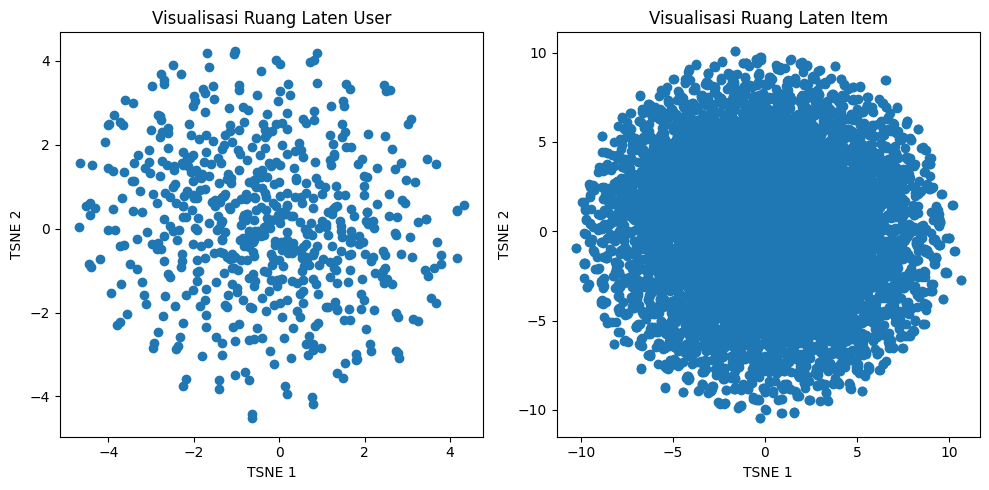

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(user_embd[:,0],user_embd[:,1])
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("Visualisasi Ruang Laten User")

plt.subplot(1,2,2)
plt.scatter(item_embd[:,0],item_embd[:,1])
plt.title("Visualisasi Ruang Laten Item")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.tight_layout()
plt.show()

#### Content Based Filtering

In [17]:
tags = pd.read_csv("../data/raw/tags.csv")
tags = tags[tags['movieId'].isin(movie_ids)]
tags.head(3)

,userId,movieId,tag,timestamp
10,18,431,Al Pacino,1462138765
11,18,431,gangster,1462138749
12,18,431,mafia,1462138755


In [18]:
tags = tags.dropna(subset=['tag'])
tags['tag'] = tags['tag'].astype(str)
tags_per_movie = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(set(x))).reset_index()
tags_per_movie.head(3),tags_per_movie.shape

(   movieId                                           tag
 0        1                                     fun pixar
 1        2  Robin Williams game fantasy magic board game
 2        3                                     old moldy,
 (1256, 2))

In [19]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

# List kalimat/tag untuk tiap movie
tag_corpus = tags_per_movie['tag'].tolist()

# Dapatkan embedding
tags_embedding = model.encode(tag_corpus, show_progress_bar=True)

import numpy as np
tags_embedding_df = pd.DataFrame(
    tags_embedding, 
    index=tags_per_movie['movieId']
)
print(tags_embedding_df.shape)

c:\Users\santu\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\santu\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\santu\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 40/40 [00:06<00:00,  5.77it/s]

(1256, 384)


In [104]:
user_persona = dict()
recommendation_cbf = dict()
movie_ids_with_tags = set(tags_embedding_df.index)

for user in train_df['userId'].unique():
    # Movie yang pernah dirating user (dan ada embedding-nya)
    ratings = train_df[train_df['userId'] == user][['movieId', 'rating']]
    ratings = ratings[ratings['movieId'].isin(movie_ids_with_tags)]
    if len(ratings) == 0:
        continue
    movie_rated = ratings['movieId'].values
    unrated_movie_ids = list(movie_ids_with_tags - set(movie_rated))
    if len(unrated_movie_ids) == 0:
        continue
    unrated = tags_embedding_df.loc[unrated_movie_ids]
    # Bangun user profile (rating-weighted)
    movie_vecs = tags_embedding_df.loc[movie_rated].values
    weights = ratings['rating'].values.reshape(-1, 1)
    user_profile = (movie_vecs * weights).sum(axis=0) / weights.sum()
    user_persona[user] = user_profile
    # Hitung similarity
    user_vec = user_profile.reshape(1, -1)
    sim_scores = cosine_similarity(user_vec, unrated.values)[0]
    # Ambil top-K
    top_n_idx = np.argpartition(-sim_scores, K)[:K]
    top_n_sorted = top_n_idx[np.argsort(-sim_scores[top_n_idx])]
    top_n_movieId = unrated.index[top_n_sorted]
    recommendation_cbf[user] = top_n_movieId.tolist()

In [105]:
print(f"Skor CBF recommender: {evaluation(K,recommendation_cbf,testset_dict)}")

Skor CBF recommender: {'precision@K_mean': 0.02459016393442623, 'recall@K_mean': 0.008459853859722867, 'hit@K_mean': 0.16393442622950818}



### 🏷️ **5. Content-Based Filtering (CBF)**

**Hasil:**

* Precision\@10: **0.025**
* Recall\@10: **0.0085**
* Hit Rate\@10: **0.164**

**Insight:**

> CBF sudah mulai memberikan rekomendasi yang personal dengan menganalisis kemiripan antar fitur (tag) film. Kelebihannya, CBF tetap bisa memberi rekomendasi meski user baru (cold start) — asalkan user sudah pernah memberi rating pada minimal satu film. Namun, kalau film belum punya tag/fitur yang cukup, kualitas rekomendasi bisa menurun.

In [ ]:
def build_rank_score(recommendation, all_items, K=10):
    """
    Build a dict: (user, movie) -> score (rank-inverse)
    """
    score_dict = {}
    for user, movies in recommendation.items():
        for rank, movie in enumerate(movies):
            score = (K - rank) / K 
            score_dict[(user, movie)] = score
        for movie in all_items - set(movies):
            score_dict[(user, movie)] = 0
    return score_dict

all_items = set(train_df['movieId'].unique())
cbf_score = build_rank_score(recommendation_cbf, all_items, K)
svd_score = build_rank_score(recommendation_svd, all_items, K)

In [106]:
alpha = 0.7
hybrid_score = {}
for key in cbf_score:
    hybrid_score[key] = alpha * svd_score.get(key, 0) + (1 - alpha) * cbf_score.get(key, 0)
    
recommendation_hybrid = defaultdict(list)
for (user, movie), score in hybrid_score.items():
    recommendation_hybrid[user].append((movie, score))
for user in recommendation_hybrid:
    recommendation_hybrid[user] = [movie for movie, _ in sorted(
        recommendation_hybrid[user], key=lambda x: x[1], reverse=True)[:K]]

score_hybrid = evaluation(K, recommendation_hybrid, testset_dict)
print(f"Skor HYBRID recommender: {score_hybrid}")

Skor HYBRID recommender: {'precision@K_mean': 0.03049180327868853, 'recall@K_mean': 0.014358183065993896, 'hit@K_mean': 0.21967213114754097}


In [107]:
switch_threshold = 5
user_train_count = train_df.groupby('userId').size().to_dict()
recommendation_switch = {}
for user in train_df['userId'].unique():
    if user_train_count[user] < switch_threshold:
        recommendation_switch[user] = recommendation_cbf.get(user, [])
    else:
        recommendation_switch[user] = recommendation_svd.get(user, [])
score_switch = evaluation(K, recommendation_switch, testset_dict)
print(f"Skor SWITCH hybrid: {score_switch}")

Skor SWITCH hybrid: {'precision@K_mean': 0.032131147540983604, 'recall@K_mean': 0.014361656718803661, 'hit@K_mean': 0.21639344262295082}


### 🔀 **6. Hybrid Model**

#### **a. Hybrid Weighted (SVD + CBF)**

**Hasil:**

* Precision\@10: **0.030**
* Recall\@10: **0.014**
* Hit Rate\@10: **0.220**

**Insight:**

> Hybrid model dengan penggabungan skor dari SVD dan CBF memberikan hasil yang sedikit lebih baik dibanding model tunggal. Gabungan ini efektif untuk menyeimbangkan kelebihan model SVD (personalization) dan CBF (fitur/kemiripan film), serta lebih tahan terhadap cold start.

#### **b. Hybrid Switch**

**Hasil:**

* Precision\@10: **0.032**
* Recall\@10: **0.014**
* Hit Rate\@10: **0.216**

**Insight:**

> Model switch memilih antara SVD atau CBF tergantung jumlah data user. Hasilnya sebanding dengan SVD saja, namun lebih robust untuk user baru. Cara ini cocok jika ingin memprioritaskan cold start tanpa menurunkan performa rata-rata.

In [27]:
tags_embedding_df.to_csv("../data/processed/tags_embedding.csv",index=False)
print("Tags embedding berhasil disimpan")

Tags embedding berhasil disimpan


### Neural Collaborative Filtering

In [108]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model

num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()
embedding_size = 64

user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

user_embedding = Embedding(num_users, embedding_size)(user_input)
item_embedding = Embedding(num_movies, embedding_size)(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

concat = Concatenate()([user_vec, item_vec])

mlp = Dense(128, activation='relu')(concat)
mlp = Dense(64, activation='relu')(mlp)
mlp = Dense(32, activation='relu')(mlp)
output = Dense(1, activation='linear')(mlp) 

model = Model([user_input, item_input], output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.fit([user_ids, movie_ids], train_df['rating'], epochs=25, batch_size=256)

Epoch 1/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.0016 - mae: 1.4899
Epoch 2/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7082 - mae: 0.6452
Epoch 3/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6331 - mae: 0.6049
Epoch 4/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.5636 - mae: 0.5681
Epoch 5/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4842 - mae: 0.5230
Epoch 6/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.4006 - mae: 0.4749
Epoch 7/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3396 - mae: 0.4368
Epoch 8/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2849 - mae: 0.3985
Epoch 9/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2448 - mae: 0.3700
Epoch 10/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2046 - mae: 0.3389
Epoch 11/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1837 - mae: 0.3218
Epoch 12/25
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1638 - mae: 0.3028
Epoch 13/25
316/3

In [109]:
user2idx = {user_id: idx for idx, user_id in enumerate(train_df['userId'].unique())}
item2idx = {item_id: idx for idx, item_id in enumerate(train_df['movieId'].unique())}

user_indices = []
item_indices = []
true_ratings = []
for (u, m, r) in testset:
    if u in user2idx and m in item2idx:
        user_indices.append(user2idx[u])
        item_indices.append(item2idx[m])
        true_ratings.append(r)
user_indices = np.array(user_indices)
item_indices = np.array(item_indices)
true_ratings = np.array(true_ratings)

In [75]:
from tqdm import tqdm
import collections

def model_recommend_ncf(model, user2idx, item2idx, user_rated, all_items, K, batch_user=50):
    idx2item = {v: k for k, v in item2idx.items()}
    users = list(user_rated.keys())
    recommendation = {}

    # Progress bar untuk batch user
    for batch_start in tqdm(range(0, len(users), batch_user), desc="NCF Recommend"):
        batch_users = users[batch_start:batch_start+batch_user]
        user_indices = []
        item_indices = []
        user_row_map = []

        for i, user in enumerate(batch_users):
            if user not in user2idx:
                continue
            u_idx = user2idx[user]
            candidate_items = list(all_items - user_rated[user])
            candidate_idx = [item2idx[m] for m in candidate_items if m in item2idx]
            user_indices.extend([u_idx] * len(candidate_idx))
            item_indices.extend(candidate_idx)
            user_row_map.extend([i] * len(candidate_idx))
        if len(user_indices) == 0:
            continue

        user_indices = np.array(user_indices)
        item_indices = np.array(item_indices)
        user_row_map = np.array(user_row_map)

        preds = model.predict([user_indices, item_indices], verbose=0).flatten()

        user_to_candidates = collections.defaultdict(list)
        user_to_scores = collections.defaultdict(list)

        for user_idx, score, item_idx in zip(user_row_map, preds, item_indices):
            user = batch_users[user_idx]
            item = idx2item[item_idx]   # O(1) lookup
            user_to_candidates[user].append(item)
            user_to_scores[user].append(score)

        for user in batch_users:
            scores = np.array(user_to_scores[user])
            items = np.array(user_to_candidates[user])
            if len(items) == 0:
                recommendation[user] = []
                continue
            top_k_idx = np.argsort(-scores)[:K]
            recommendation[user] = items[top_k_idx].tolist()
    return recommendation

recommendation_ncf = model_recommend_ncf(
    model, user2idx, item2idx, user_rated, all_items, K, batch_user=50
)

NCF Recommend: 100%|██████████| 13/13 [06:47<00:00, 31.34s/it]


In [112]:
score_ncf = evaluation(K, recommendation_ncf, testset_dict)
print(f"Skor NCF recommender: {score_ncf}")

Skor NCF recommender: {'precision@K_mean': 0.005573770491803278, 'recall@K_mean': 0.003141099576354959, 'hit@K_mean': 0.08852459016393442}


### 🤖 **6. Neural Collaborative Filtering (NCF)**

**Hasil:**

* Precision\@10: **0.0056**
* Recall\@10: **0.0031**
* Hit Rate\@10: **0.088**

**Insight:**

> Meskipun NCF berbasis neural network dan potensinya besar, pada eksperimen ini performanya masih di bawah SVD maupun CBF. Hal ini kemungkinan karena model butuh tuning lebih lanjut (epoch, layer, regularisasi) atau data MovieLens 100k yang kecil untuk deep learning. Ke depannya, model NCF bisa dilatih lebih lama atau dengan dataset lebih besar agar hasilnya optimal.

In [169]:
import pickle

with open("../models/model_svd.pkl", "wb") as f:
    pickle.dump(algo_svd, f)

with open("../models/model_usercf.pkl", "wb") as f:
    pickle.dump(algo_user, f)

with open("../models/model_lightfm_popularity.pkl", "wb") as f:
    pickle.dump(popularity_model, f)

with open("../models/model_lightfm_random.pkl", "wb") as f:
    pickle.dump(random_model, f)

model.save("../models/model_ncf.h5")

with open("../models/user_mapping.pkl", "wb") as f:
    pickle.dump(user_mapping, f)

with open("../models/item_mapping.pkl", "wb") as f:
    pickle.dump(item_mapping, f)
    
tags_embedding_df.to_pickle("../models/tags_embedding.pkl")

train_df.to_csv("../data/processed/train_df.csv",index=False)

In [154]:
movies = pd.read_csv('../data/raw/movies.csv')

def recommend_for_user_table(user_id, model, K=10):
    user_idx = user_mapping[user_id]
    rated_items = set(train_df[train_df['userId'] == user_id]['movieId'].unique())
    all_items = set(train_df['movieId'].unique())
    candidate_items = list(all_items - rated_items)
    candidate_indices = [item_mapping[mid] for mid in candidate_items]
    scores = model.predict(user_ids=user_idx, item_ids=np.array(candidate_indices))
    top_k_idx = np.argsort(-scores)[:K]
    top_movieids = [candidate_items[i] for i in top_k_idx]
    df_result = pd.DataFrame({'movieId': top_movieids})
    df_result = df_result.merge(movies, on='movieId', how='left')
    return df_result[['movieId', 'title', 'genres']]

def recommend_surprise_for_user(user_id, algo, K=10):
    rated_items = set(train_df[train_df['userId'] == user_id]['movieId'].unique())
    all_items = set(train_df['movieId'].unique())
    candidate_items = list(all_items - rated_items)
    preds = [(iid, algo.predict(str(user_id), str(iid)).est) for iid in candidate_items]
    top_items = sorted(preds, key=lambda x: x[1], reverse=True)[:K]
    top_movieids = [iid for iid, score in top_items]
    top_scores = [score for iid, score in top_items]
    df_result = pd.DataFrame({'movieId': top_movieids, 'score': top_scores})
    df_result = df_result.merge(movies, on='movieId', how='left')
    return df_result[['movieId', 'title', 'genres', 'score']]

def recommend_ncf_for_user(user_id, model, user2idx, item2idx, train_df, movies, K=10):
    # Ambil item yang belum dirating user di train
    rated_items = set(train_df[train_df['userId'] == user_id]['movieId'].unique())
    all_items = set(train_df['movieId'].unique())
    candidate_items = list(all_items - rated_items)
    if user_id not in user2idx or len(candidate_items) == 0:
        return pd.DataFrame(columns=['movieId', 'title', 'genres'])
    u_idx = user2idx[user_id]
    candidate_idx = [item2idx[m] for m in candidate_items if m in item2idx]
    if not candidate_idx:
        return pd.DataFrame(columns=['movieId', 'title', 'genres'])
    user_arr = np.full(len(candidate_idx), u_idx)
    item_arr = np.array(candidate_idx)
    # Predict dalam batch
    scores = model.predict([user_arr, item_arr], verbose=0).flatten()
    top_k_idx = np.argsort(-scores)[:K]
    top_movieids = [candidate_items[i] for i in top_k_idx]
    df_result = pd.DataFrame({'movieId': top_movieids})
    df_result = df_result.merge(movies, on='movieId', how='left')
    return df_result[['movieId', 'title', 'genres']]


def recommend_cbf_for_user(user_id, train_df, tags_embedding_df, movies, K=10):
    movie_ids_with_tags = set(tags_embedding_df.index)
    ratings = train_df[train_df['userId'] == user_id][['movieId', 'rating']]
    ratings = ratings[ratings['movieId'].isin(movie_ids_with_tags)]
    if len(ratings) == 0:
        return pd.DataFrame(columns=['movieId', 'title', 'genres'])
    movie_rated = ratings['movieId'].values
    unrated_movie_ids = list(movie_ids_with_tags - set(movie_rated))
    if len(unrated_movie_ids) == 0:
        return pd.DataFrame(columns=['movieId', 'title', 'genres'])
    unrated = tags_embedding_df.loc[unrated_movie_ids]
    movie_vecs = tags_embedding_df.loc[movie_rated].values
    weights = ratings['rating'].values.reshape(-1, 1)
    user_profile = (movie_vecs * weights).sum(axis=0) / weights.sum()
    user_vec = user_profile.reshape(1, -1)
    sim_scores = cosine_similarity(user_vec, unrated.values)[0]
    top_n_idx = np.argpartition(-sim_scores, K)[:K]
    top_n_sorted = top_n_idx[np.argsort(-sim_scores[top_n_idx])]
    top_n_movieId = unrated.index[top_n_sorted]
    df_result = pd.DataFrame({'movieId': top_n_movieId})
    df_result = df_result.merge(movies, on='movieId', how='left')
    return df_result[['movieId', 'title', 'genres']]

def recommend_switch_for_user_table(user_id, train_df, recommendation_cbf, recommendation_svd, user_train_count, switch_threshold, movies, K=10):
    if user_train_count.get(user_id, 0) < switch_threshold:
        rec_list = recommendation_cbf.get(user_id, [])[:K]
    else:
        rec_list = recommendation_svd.get(user_id, [])[:K]
    df_result = pd.DataFrame({'movieId': rec_list})
    df_result = df_result.merge(movies, on='movieId', how='left')
    return df_result[['movieId', 'title', 'genres']]

def recommend_hybrid_for_user_table(user_id, svd_score, cbf_score, alpha, movies, K=10):
    # Ambil semua item yang ada di skor
    candidate_movies = set()
    candidate_movies.update([k[1] for k in svd_score if k[0] == user_id])
    candidate_movies.update([k[1] for k in cbf_score if k[0] == user_id])
    scores = []
    for movie in candidate_movies:
        score = alpha * svd_score.get((user_id, movie), 0) + (1 - alpha) * cbf_score.get((user_id, movie), 0)
        scores.append((movie, score))
    top_movies = [movie for movie, _ in sorted(scores, key=lambda x: x[1], reverse=True)[:K]]
    df_result = pd.DataFrame({'movieId': top_movies})
    df_result = df_result.merge(movies, on='movieId', how='left')
    return df_result[['movieId', 'title', 'genres']]

user_id = 1
top10_pop_table = recommend_for_user_table(user_id, popularity_model, K=10)
top10_random_table = recommend_for_user_table(user_id, random_model, K=10)
top10_usercf = recommend_surprise_for_user(user_id, algo_user, K=10)
top10_svd = recommend_surprise_for_user(user_id, algo_svd, K=10)
top10_ncf = recommend_ncf_for_user(user_id, model, user2idx, item2idx, train_df, movies, K=10)
top10_cbf = recommend_cbf_for_user(user_id, train_df, tags_embedding_df, movies, K=10)
top10_switch = recommend_switch_for_user_table(user_id, train_df, recommendation_cbf, recommendation_svd, user_train_count, switch_threshold, movies, K=10)
top10_hybrid = recommend_hybrid_for_user_table(user_id, svd_score, cbf_score, alpha=0.7, movies=movies, K=10)

In [155]:
top10_pop_table

,movieId,title,genres
0,318,"Shawshank Redemption, The (1994)",Crime|Drama
1,527,Schindler's List (1993),Drama|War
2,150,Apollo 13 (1995),Adventure|Drama|IMAX
3,2959,Fight Club (1999),Action|Crime|Drama|Thriller
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
6,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
7,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
8,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi
9,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX


In [156]:
top10_random_table

,movieId,title,genres
0,97306,Seven Psychopaths (2012),Comedy|Crime
1,37731,Green Street Hooligans (a.k.a. Hooligans) (2005),Crime|Drama
2,2383,Police Academy 6: City Under Siege (1989),Comedy|Crime
3,2512,"Ballad of Narayama, The (Narayama bushiko) (1983)",Drama
4,47254,Chaos (2005),Action|Crime|Drama|Thriller
5,7317,EuroTrip (2004),Adventure|Comedy
6,54272,"Simpsons Movie, The (2007)",Animation|Comedy
7,70208,"Perfect Getaway, A (2009)",Horror|Thriller
8,65230,Marley & Me (2008),Comedy|Drama
9,159779,A Midsummer Night's Dream (2016),(no genres listed)


In [157]:
top10_svd

,movieId,title,genres,score
0,2,Jumanji (1995),Adventure|Children|Fantasy,3.503041
1,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.503041
2,5,Father of the Bride Part II (1995),Comedy,3.503041
3,7,Sabrina (1995),Comedy|Romance,3.503041
4,8,Tom and Huck (1995),Adventure|Children,3.503041
5,9,Sudden Death (1995),Action,3.503041
6,10,GoldenEye (1995),Action|Adventure|Thriller,3.503041
7,11,"American President, The (1995)",Comedy|Drama|Romance,3.503041
8,12,Dracula: Dead and Loving It (1995),Comedy|Horror,3.503041
9,13,Balto (1995),Adventure|Animation|Children,3.503041


In [158]:
top10_usercf

,movieId,title,genres,score
0,2,Jumanji (1995),Adventure|Children|Fantasy,3.503041
1,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3.503041
2,5,Father of the Bride Part II (1995),Comedy,3.503041
3,7,Sabrina (1995),Comedy|Romance,3.503041
4,8,Tom and Huck (1995),Adventure|Children,3.503041
5,9,Sudden Death (1995),Action,3.503041
6,10,GoldenEye (1995),Action|Adventure|Thriller,3.503041
7,11,"American President, The (1995)",Comedy|Drama|Romance,3.503041
8,12,Dracula: Dead and Loving It (1995),Comedy|Horror,3.503041
9,13,Balto (1995),Adventure|Animation|Children,3.503041


In [159]:
top10_cbf

,movieId,title,genres
0,4029,State and Main (2000),Comedy|Drama
1,6368,Cinemania (2002),Documentary
2,413,Airheads (1994),Comedy
3,7439,"Punisher, The (2004)",Action|Crime|Thriller
4,594,Snow White and the Seven Dwarfs (1937),Animation|Children|Drama|Fantasy|Musical
5,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
6,1282,Fantasia (1940),Animation|Children|Fantasy|Musical
7,2078,"Jungle Book, The (1967)",Animation|Children|Comedy|Musical
8,2080,Lady and the Tramp (1955),Animation|Children|Comedy|Romance
9,616,"Aristocats, The (1970)",Animation|Children


In [160]:
top10_ncf

,movieId,title,genres
0,172,Johnny Mnemonic (1995),Action|Sci-Fi|Thriller
1,2931,Time of the Gypsies (Dom za vesanje) (1989),Comedy|Crime|Drama|Fantasy
2,102823,As I Was Moving Ahead Occasionally I Saw Brief...,Documentary
3,2014,Freaky Friday (1977),Children|Comedy|Fantasy
4,4323,"Horse Soldiers, The (1959)",Adventure|War|Western
5,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX
6,1207,To Kill a Mockingbird (1962),Drama
7,96121,Hope Springs (2012),Comedy|Drama
8,6804,Crimewave (1985),Comedy|Crime
9,4697,Basket Case (1982),Comedy|Horror


In [161]:
top10_switch

,movieId,title,genres
0,318,"Shawshank Redemption, The (1994)",Crime|Drama
1,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
2,1204,Lawrence of Arabia (1962),Adventure|Drama|War
3,741,Ghost in the Shell (Kôkaku kidôtai) (1995),Animation|Sci-Fi
4,1223,"Grand Day Out with Wallace and Gromit, A (1989)",Adventure|Animation|Children|Comedy|Sci-Fi
5,1104,"Streetcar Named Desire, A (1951)",Drama
6,1248,Touch of Evil (1958),Crime|Film-Noir|Thriller
7,2019,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama
8,3468,"Hustler, The (1961)",Drama
9,2959,Fight Club (1999),Action|Crime|Drama|Thriller


In [162]:
top10_hybrid

,movieId,title,genres
0,318,"Shawshank Redemption, The (1994)",Crime|Drama
1,741,Ghost in the Shell (Kôkaku kidôtai) (1995),Animation|Sci-Fi
2,1204,Lawrence of Arabia (1962),Adventure|Drama|War
3,1272,Patton (1970),Drama|War
4,1104,"Streetcar Named Desire, A (1951)",Drama
5,1262,"Great Escape, The (1963)",Action|Adventure|Drama|War
6,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
7,106642,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi
8,71899,Mary and Max (2009),Animation|Comedy|Drama
9,3037,Little Big Man (1970),Western


## 📌 **Kesimpulan Umum**

* Model **popularity** sudah jadi baseline yang cukup kuat, tapi tidak personal.
* **SVD** dan **hybrid** mampu mengalahkan baseline dan mulai relevan secara personal.
* **NCF** perlu tuning lebih lanjut, performa saat ini belum maksimal.
* **Hybrid** (khususnya weighted) memberikan best-of-both-worlds: personalisasi + kemampuan cold start.
* **CBF** tetap penting untuk user baru dan film dengan sedikit rating.

---

## 📊 **Rekap Tabel Hasil Akhir**

| Model         | Precision\@10 | Recall\@10 | Hit Rate\@10 |
| ------------- | ------------- | ---------- | ------------ |
| Random        | 0.005         | 0.0016     | 0.051        |
| Popularity    | 0.145         | 0.067      | 0.60         |
| User-User CF  | 0.009         | 0.0037     | 0.074        |
| SVD           | 0.032         | 0.014      | 0.216        |
| CBF           | 0.025         | 0.0085     | 0.164        |
| NCF           | 0.0056        | 0.0031     | 0.088        |
| Hybrid        | 0.030         | 0.014      | 0.220        |
| Switch Hybrid | 0.032         | 0.014      | 0.216        |